### Import of libraries, reading of the CSV and global information of the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import json

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Classification algorithms

### Decision Tree

#### data transformation

In [2]:
# Field renaming to normalize case:
df = df.rename(columns={'customerID':'CustomerID',
                       'gender':'Gender',
                       'tenure':'Tenure'})

# I eliminate the variables that I am not interested in considering (I previously showed that they do not influence)
df2 = df.drop(columns = ["CustomerID","Gender"])

# Remove fields where TotalCharges is empty and convert to numeric
df2['TotalCharges'] = pd.to_numeric(df2['TotalCharges'], errors = "coerce")
df2['TotalCharges'].replace('', np.nan, inplace=True)
df2.dropna(subset=['TotalCharges'], inplace=True)

# Since some algorithms do not support categorical variables, I discretize them into binary numeric variables
df2.Dependents = df2.Dependents.replace({'No':0, 'Yes':1})
df2.Partner = df2.Partner.replace({'No':0, 'Yes':1})
df2.PhoneService = df2.PhoneService.replace({'No':0, 'Yes':1, 'No phone service': 2})
df2.MultipleLines = df2.MultipleLines.replace({'No':0, 'Yes':1, 'No phone service': 2})
df2.InternetService = df2.InternetService.replace({'DSL':0, 'Fiber optic':1, 'No': 2})
df2.OnlineSecurity = df2.OnlineSecurity.replace({'No':0, 'Yes':1, 'No internet service': 2})
df2.OnlineBackup = df2.OnlineBackup.replace({'No':0, 'Yes':1, 'No internet service': 2})
df2.DeviceProtection = df2.DeviceProtection.replace({'No':0, 'Yes':1, 'No internet service': 2})
df2.TechSupport = df2.TechSupport.replace({'No':0, 'Yes':1, 'No internet service': 2})
df2.StreamingTV = df2.StreamingTV.replace({'No':0, 'Yes':1, 'No internet service': 2})
df2.StreamingMovies = df2.StreamingMovies.replace({'No':0, 'Yes':1, 'No internet service': 2})
df2.Contract = df2.Contract.replace({'Month-to-month':0, 'One year':1, 'Two year':2})
df2.PaperlessBilling = df2.PaperlessBilling.replace({'No':0, 'Yes':1})
df2.PaymentMethod = df2.PaymentMethod.replace({'Electronic check':0, 'Mailed check':1, 
                                                     'Bank transfer (automatic)':2, 'Credit card (automatic)':3})
df2.Churn = df2.Churn.replace({'No':0, 'Yes':1})
df2

,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,2,0,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,0,0,0,34,1,0,0,1,0,1,0,0,0,1,0,1,56.95,1889.50,0
2,0,0,0,2,1,0,0,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,0,0,0,45,0,2,0,1,0,1,1,0,0,1,0,2,42.30,1840.75,0
4,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,1,1,24,1,1,0,1,0,1,1,1,1,1,1,1,84.80,1990.50,0
7039,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,3,103.20,7362.90,0
7040,0,1,1,11,0,2,0,1,0,0,0,0,0,0,1,0,29.60,346.45,0
7041,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,1,74.40,306.60,1


#### Required Libraries

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Create and train the model

In [4]:
# Generate the model
tree = DecisionTreeClassifier(random_state=10) # max_depth = 2

# Separation in X and Y
x = df2.drop("Churn", axis = 1)
y = df2.Churn

# I separate the set into training and test/validation (70%-30%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

# train the model
tree.fit(x_train, y_train)

# Make the prediction on the sets
y_train_pred = tree.predict(x_train)
y_test_pred = tree.predict(x_test)

#### Evaluation

In [5]:
# Calculate the accuracy of the predictions:
train_acc = accuracy_score(y_train, y_train_pred)
print(f"The percentage of hits on the training set is: {round(train_acc * 100, 2)} %")
test_acc = accuracy_score(y_test, y_test_pred)
print(f"The percentage of hits on the evaluation set is: {round(test_acc * 100, 2)} %")

The percentage of hits on the training set is: 99.76 %
The percentage of hits on the evaluation set is: 72.13 %


### Random Forest

#### Required Libraries

In [6]:
from sklearn.ensemble import RandomForestClassifier

#### Create and train the model

In [7]:
# generate the model
model = RandomForestClassifier(random_state = 10, n_estimators = 200,
                                class_weight = "balanced", max_features = "log2")

# We separate the set into training and test/validation (70%-30%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

# train the model
model.fit(x_train, y_train)

# Make the prediction on the test set
y_test_pred_rf = model.predict(x_test)

#### Evaluation

In [8]:
# Calculate the accuracy of the predictions:
print(f"Percentage of hits with Decision Tree was: {round(test_acc * 100, 2)} %")
test_acc_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"Percentage of hits with Random Forest is: {round(test_acc_rf * 100, 2)} %")

Percentage of hits with Decision Tree was: 72.13 %
Percentage of hits with Random Forest is: 79.57 %


### K Near neighbors (KNN)

##### I have a set of n = 7000 records and 3 numeric variables. I will use an initial value of k=10 and relationships between the Dwell Time (tenure) and the Monthly Service Cost

#### Required Libraries

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

#### Scatter Plot

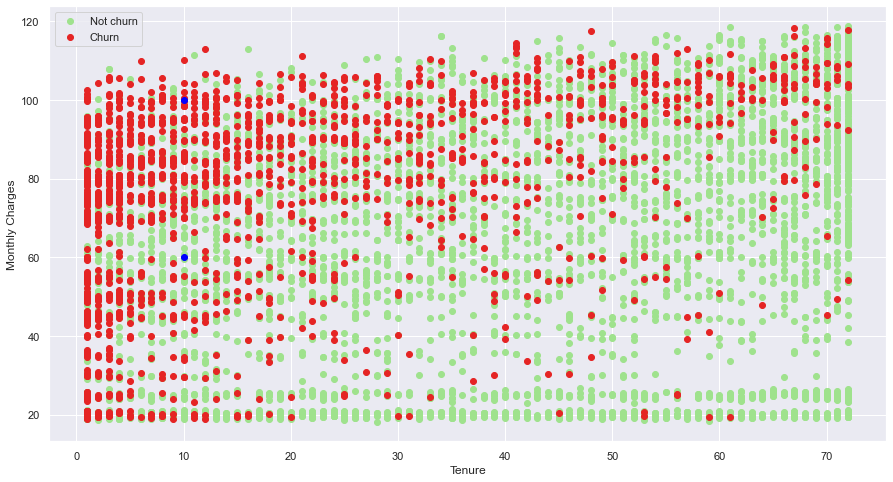

In [11]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(15,8)})

new_point_1 = pd.DataFrame({'Tenure':[10], 'MonthlyCharges':[100]})
new_point_2 = pd.DataFrame({'Tenure':[10], 'MonthlyCharges':[60]})

ax = plt.axes()

ax.scatter(df2.loc[df2['Churn'] == 0, "Tenure"],
           df2.loc[df2['Churn'] == 0, "MonthlyCharges"],
           c = '#9FE28D',
           label = 'Not churn')
ax.scatter(df2.loc[df2['Churn'] == 1, "Tenure"],
           df2.loc[df2['Churn'] == 1, "MonthlyCharges"],
           c = '#E52424',
           label = 'Churn')
ax.scatter(new_point_1["Tenure"],
           new_point_1["MonthlyCharges"],
           c = 'blue')
ax.scatter(new_point_2["Tenure"],
           new_point_2["MonthlyCharges"],
           c = 'blue')

plt.xlabel("Tenure")
plt.ylabel("Monthly Charges")
ax.legend()
plt.show()

#### Model building and unit predictions

In [12]:
# generate the model
knn = KNeighborsClassifier(n_neighbors = 10)
X = df[['Tenure', 'MonthlyCharges']]
Y = df['Churn']

# train the model
knn.fit(X, Y)
#knn.fit(X,np.ravel(y_train,order='C'))

# make the prediction
prediction_knn_1 = knn.predict(new_point_1)
prediction_knn_1_prob = knn.predict_proba(new_point_1)
prediction_knn_2 = knn.predict(new_point_2)
prediction_knn_2_prob = knn.predict_proba(new_point_2)

# Results
print(f"Point 1 abandonment prediction: {prediction_knn_1} with a probability of {prediction_knn_1_prob[0][0]*100} %")
print(f"Prediction of abandonment of point 2: {prediction_knn_2} with a probability of {prediction_knn_2_prob[0][0]*100} %")

Point 1 abandonment prediction: ['Yes'] with a probability of 20.0 %
Prediction of abandonment of point 2: ['No'] with a probability of 100.0 %


#### Test Set Prediction

In [21]:
# generate the model
knn = KNeighborsClassifier(n_neighbors = 10)

# We separate the set into training and test/validation (70%-30%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

#Preprocessing
#scaler = preprocessing.StandardScaler().fit(x_train)
#x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

# train the model
knn.fit(x_train, y_train)

# Make the prediction on the test set
y_test_pred = knn.predict(x_test)

# Calculate the accuracy of the predictions:
test_acc_knn = accuracy_score(y_test, y_test_pred)
print(f"Percentage of hits with K near neighbors is: {round(test_acc_knn * 100, 2)} %")

Percentage of hits with K near neighbors is: 77.82 %


#### Accuracy optimization with K selection (Jambu Elbow)

In [23]:
# Making an error rate list
error_rate = []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    error_rate.append(np.mean(pred_i != y_test))

<function matplotlib.pyplot.show(close=None, block=None)>

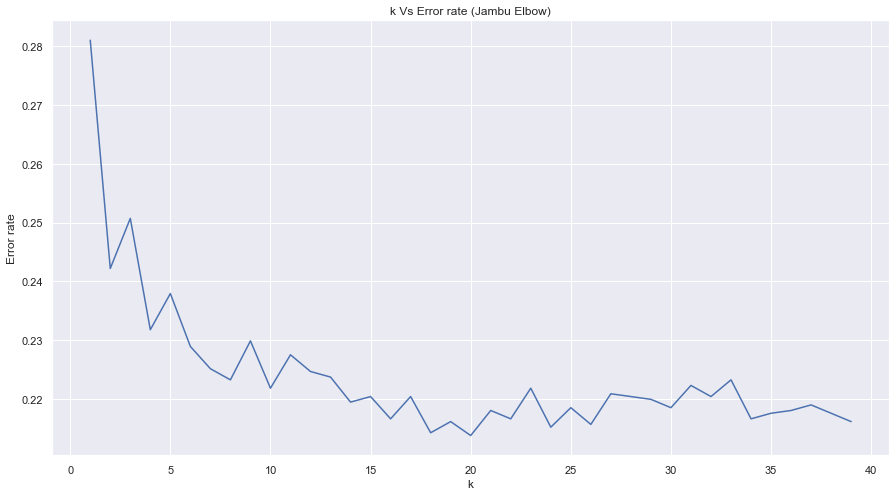

In [24]:
# Plotting that list to see

plt.plot(range(1,40), error_rate)

plt.title('k Vs Error rate (Jambu Elbow)')

plt.xlabel('k')
plt.ylabel('Error rate')
plt.show

##### It can be seen that the optimal K would be given for k=20, but k=19 is chosen so that it is odd

#### New prediction with optimal k

In [25]:
# generate the model
knn_opt = KNeighborsClassifier(n_neighbors = 19)

# We separate the set into training and test/validation (70%-30%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 10)

#Preprocessing
#scaler = preprocessing.StandardScaler().fit(x_train)
#x_train = scaler.transform(x_train)
#x_test = scaler.transform(x_test)

# train the model
knn_opt.fit(x_train, y_train)

# Make the prediction on the test set
y_test_pred_opt = knn_opt.predict(x_test)

# Calculate the accuracy of the predictions:
test_acc_knn_opt = accuracy_score(y_test, y_test_pred_opt)
print(f"Percentage of hits with KNN with n=10 is: {round(test_acc_knn * 100, 2)} %")
print(f"Percentage of hits with KNN with n=19 (optimal) is: {round(test_acc_knn_opt * 100, 2)} %")

Percentage of hits with KNN with n=10 is: 77.82 %
Percentage of hits with KNN with n=19 (optimal) is: 78.39 %


### Logistic regression

##### Since I want to obtain a discrete output I will use logistic regression. I will take the relationship between Total Charges and Churn

#### Required libraries

In [26]:
from sklearn.linear_model import LogisticRegression

#### Scatter plot

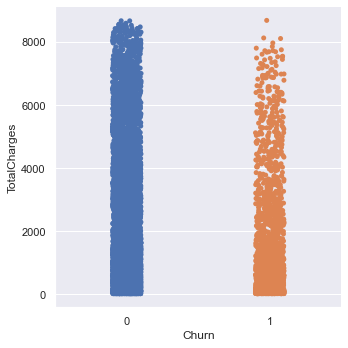

In [27]:
sns.catplot(y="TotalCharges", x="Churn", data=df2)

#### Model creation and predictions

In [28]:
# Logistic regression instance:
logreg = LogisticRegression()

x = df2[['TotalCharges']].values
y = df2['Churn'].values

# Regression training:
logreg.fit(x, y)

# Pass new values to predict, as an array
x_new = np.array([50, 500, 2000, 4000, 6000, 8000, 9000]).reshape(-1,1)

# Prediction:
prediction = logreg.predict(x_new)
prediction_prob = logreg.predict_proba(x_new)

print("For values: \n", x_new)
print("The prediction is: \n", prediction.reshape(-1,1))
print("With probabilities of: \n",prediction_prob.round(2) * 100)
print(f"Prediction of abandonment with Cumulative Billing of {x_new[2]}: {prediction[0]}, \
with a probability of {round(prediction_prob[0][0]*100, 2)} %")

For values: 
 [[  50]
 [ 500]
 [2000]
 [4000]
 [6000]
 [8000]
 [9000]]
The prediction is: 
 [[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
With probabilities of: 
 [[64. 36.]
 [66. 34.]
 [73. 27.]
 [82. 18.]
 [88. 12.]
 [92.  8.]
 [94.  6.]]
Prediction of abandonment with Cumulative Billing of [2000]: 0, with a probability of 63.57 %


##### Seeing the graph and also the results, I observe that the logistic regression model does not give good predictive results. It can only accurately predict when we are talking about very large accumulated total billing values (long-standing customers), so it is discarded.

### SVM (Support vector machines)

##### I will take the relationship between the length of stay and the monthly cost of the service

#### Scatter plot

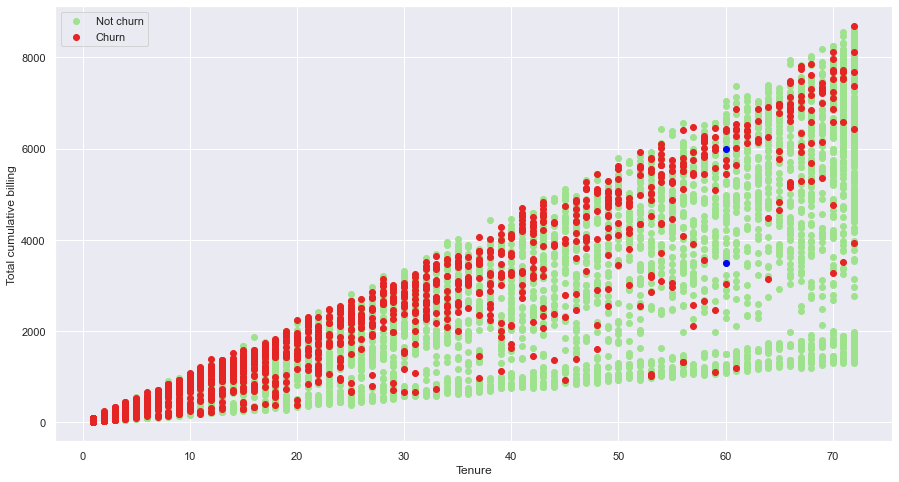

In [29]:
new_point_1 = pd.DataFrame({'Tenure':[60], 'TotalCharges':[3500]})
new_point_2 = pd.DataFrame({'Tenure':[60], 'TotalCharges':[6000]})

ax = plt.axes()

ax.scatter(df2.loc[df2['Churn'] == 0, "Tenure"],
            df2.loc[df2['Churn'] == 0, "TotalCharges"],
            c = '#9FE28D',
            label = 'Not churn')
ax.scatter(df2.loc[df2['Churn'] == 1, "Tenure"],
            df2.loc[df2['Churn'] == 1, "TotalCharges"],
            c = '#E52424',
            label = 'Churn')
ax.scatter(new_point_1["Tenure"],
            new_point_1["TotalCharges"],
            c = 'blue')
ax.scatter(new_point_2["Tenure"],
            new_point_2["TotalCharges"],
            c = 'blue')

plt.xlabel("Tenure")
plt.ylabel("Total cumulative billing")
ax.legend()
plt.show()

#### Required libraries

In [31]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

#### Model creation and predictions

In [32]:
# We separate the set into training and test/validation (70%-30%)
X = df[['Tenure', 'MonthlyCharges']]
y = df['Churn']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

# We generate the models (using the 4 functions)
linear = svm.SVC(kernel = 'linear', C = 1, decision_function_shape = 'ovo')
rbf = svm.SVC(kernel = 'rbf', gamma = 1, C = 1, decision_function_shape = 'ovo')
poly = svm.SVC(kernel = 'poly', degree = 3, C = 1, decision_function_shape = 'ovo')
sig = svm.SVC(kernel = 'sigmoid', C = 1, decision_function_shape = 'ovo')

# We train the models
linear.fit(x_train, y_train)
rbf.fit(x_train, y_train)
poly.fit(x_train, y_train)
sig.fit(x_train, y_train)


SVC(C=1, decision_function_shape='ovo', kernel='sigmoid')

#### Visualization graph of the 4 kernels

In [ ]:
# Base-mesh creation
h = .02  # step size in the mesh
C = 1.0  # SVM regularization parameter

X2 = X.to_numpy()
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots

titles = ['Linear kernel', 'RBF kernel', 'Polynomial kernel', 'Sigmoid kernel']

for i, clf in enumerate((linear, rbf, poly, sig)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot also the training points
    plt.scatter(X2[:, 0], X2[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Tenure')
    plt.ylabel('Monthly Charges')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()

#### Predictions and Results

In [33]:
# make the prediction
linear_pred = linear.predict(x_test)
rbf_pred = rbf.predict(x_test)
poly_pred = poly.predict(x_test)
sig_pred = sig.predict(x_test)

# Results
linear_acc = linear.score(x_test, y_test)
rbf_acc = rbf.score(x_test, y_test)
poly_acc = poly.score(x_test, y_test)
sig_acc = sig.score(x_test, y_test)

# Results
print(f"precision with linear kernel: {round(linear_acc * 100, 2)} %")
print(f"precision with polynomial kernel: {round(rbf_acc * 100, 2)} %")
print(f"precision with Radial Basis kernel: {round(poly_acc * 100, 2)} %")
print(f"precision with Sigmoid kernel: {round(sig_acc * 100, 2)} %")

precision with linear kernel: 77.95 %
precision with polynomial kernel: 76.34 %
precision with Radial Basis kernel: 79.18 %
precision with Sigmoid kernel: 61.43 %


#### Error matrix

In [34]:
cm_linear = confusion_matrix(y_test, linear_pred)
cm_rbf = confusion_matrix(y_test, rbf_pred)
cm_poly = confusion_matrix(y_test, poly_pred)
cm_sig = confusion_matrix(y_test, sig_pred)
print(f"{cm_linear} \n {cm_rbf} \n {cm_poly} \n {cm_sig}")

[[1386  170]
 [ 296  261]] 
 [[1412  144]
 [ 356  201]] 
 [[1472   84]
 [ 356  201]] 
 [[1147  409]
 [ 406  151]]


##### Of all the classification models, the one that has given the best results is the random forest model with 79.57%. Although it could be considered that it is not a very high percentage, given that the error is not critical, We consider it useful. The client could act on those clients that the algorithm considers could desert, as long as the extra cost for that action is less than losing those clients and considering that almost 20% probability of error.